In [2]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt

from dataclasses import dataclass, asdict, field
import json
import os
from typing import Any

@dataclass
class Configuration:
    # --------- Data settings ---------
    data_dir: str = '/content/gdrive/MyDrive/dataset/Data'
    width: int = 200
    height: int = 200
    dim: int = 3

    # ------- ConvolutionBlock settings  --------
    kernel_size: tuple[int, int] = (3, 3)
    n_convolutions_per_block: int = 2
    use_batch_norm: bool = True
    activation: str = 'relu'

    # ------- Encoder/Decoder settings -------
    # Number of kernels in first level of Encoder, doubles/halves at each level in Encoder/Decoder
    n_kernels_init: int = 64
    # Number of resolutions/blocks; height of U-Net
    n_levels: int = 4
    # Number of class to predict
    n_kernels_last: int = 1
    # Use sigmoid if using binary crossentropy, softmax if using categorical crossentropy
    # Note if using softmax, n_kernels_last should be equal to number of classes (e.g. 2 for binary segmentation)
    # If None, loss will use from_logits=True
    final_layer_activation: str = 'sigmoid'

    # ------- Overall U-Net settings -----------------
    model_checkpoint_path: str = '/content/gdrive/MyDrive/checkpoint.model.keras'
    n_epochs: int = 1
    batch_size: int = 32
    metrics: list[str] = field(default_factory=lambda: ['accuracy'])
    # Must be str to avoid get_config() error
    initializer: str = 'he_normal' # For kernel initialisation
    optimizer: keras.optimizers.Optimizer = keras.optimizers.Adam
    loss: keras.losses.Loss = keras.losses.BinaryCrossentropy
    # Learning rate scheduler, decrease learning rate at certain epochs
    lr_scheduler: Any = keras.optimizers.schedules.PiecewiseConstantDecay
    # Percentage of training where learning rate is decreased
    lr_schedule_percentages: list[float] = field(default_factory=lambda: [0.2, 0.5, 0.8])
    # Gradually decrease learning rate, starting at first value
    lr_schedule_values: list[float] = field(default_factory=lambda: [3e-4, 1e-4, 1e-5, 1e-6])


    def __post_init__(self):
        # Explicitly calculate number of kernels per block (for Encoder)
        self.n_kernels_per_block: list[int] = [
            self.n_kernels_init * (2 ** block_level)
            for block_level in range(self.n_levels)
        ]

    def dict(self):
        _dict = self.__dict__.copy()
        _dict['n_kernels_per_block'] = self.n_kernels_per_block
        return _dict

    def save_json(self, filename="configuration.json") -> None:
      with open(filename, 'w') as f:
          json.dump(self.dict(), f, indent=4)


2024-08-05 15:00:22.404611: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-05 15:00:22.405782: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-05 15:00:22.410859: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-05 15:00:22.423434: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-05 15:00:22.449305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [3]:
class ConvolutionBlock(layers.Layer):
    def __init__(self, n_kernels: int, config: Configuration):
        """
        Block of multiple convolutions.
        """
        self.config = config
        super(ConvolutionBlock, self).__init__()
        self.n_kernels = n_kernels
        self.n_convolutions = config.n_convolutions_per_block
        self.kernel_size = config.kernel_size
        self.use_batch_norm = config.use_batch_norm

        self.conv_layers = [
            layers.Conv2D(n_kernels, self.kernel_size, kernel_initializer=config.initializer, padding='same')
            for _ in range(self.n_convolutions)
        ]
        self.activations = [
            layers.Activation(config.activation)
            for _ in range(self.n_convolutions)
        ]
        if config.use_batch_norm:
            self.batch_norm_layers = [
                layers.BatchNormalization()
                for _ in range(self.n_convolutions)
            ]

    def call(self, inputs, training=False):
        """
        Pass inputs through series of convolutions.
        """
        x = inputs
        for idx, (conv_layer, activation) in enumerate(zip(self.conv_layers, self.activations)):
            x = conv_layer(x)
            if self.use_batch_norm:
                x = self.batch_norm_layers[idx](x, training=training)
            x = activation(x)
        return x

    def get_config(self):
        return self.config.dict() | {'n_kernels': self.n_kernels}

class Encoder(layers.Layer):
    """
    Contracting path of multiple convolutional blocks with downsampling
    """
    def __init__(self, config: Configuration):
        super(Encoder, self).__init__()
        self.config = config
        self.n_levels = config.n_levels
        self.n_kernels_per_block = config.n_kernels_per_block

        self.conv_blocks = [
            ConvolutionBlock(
                config.n_kernels_per_block[level],
                config
            )
            for level in range(config.n_levels)
        ]
        self.downsample = layers.MaxPool2D((2, 2), strides=(2, 2))

    def call(self, inputs, training=False):
        """
        Pass inputs through encoder path and return (n_levels - 1) skip inputs (last
        block have no skip connection).
        """
        skip_inputs = []
        x = inputs
        for idx, conv_block in enumerate(self.conv_blocks):
            x = conv_block(x, training=training)

            # Downsample if not the last level
            if idx != self.n_levels - 1:
                skip_inputs.append(x)   # Skip connection for this level
                x = self.downsample(x)

        return x, skip_inputs

    def get_config(self):
        return self.config.dict()

class Decoder(layers.Layer):
    def __init__(self, config: Configuration):
        super(Decoder, self).__init__()
        self.config = config
        # Bottleneck level is considered part of encoder
        self.n_levels = config.n_levels - 1
        # reverse kernel order to match encoder, and ignore first level (bottleneck)
        self.n_kernels_per_block = config.n_kernels_per_block[::-1][1:]

        self.conv_blocks = [
            ConvolutionBlock(
                n_kernels,
                config
            )
            for n_kernels in self.n_kernels_per_block
        ]

        # Final 1x1 convolution to make prediction
        self.last_conv = layers.Conv2D(
            config.n_kernels_last, (1, 1), kernel_initializer=config.initializer, padding='same'
        )
        if config.final_layer_activation is not None:
            self.last_activation = layers.Activation(config.final_layer_activation)

        self.upsample = [
            layers.Conv2DTranspose(
                n_kernels // 2, config.kernel_size, strides=(2, 2),
                kernel_initializer=config.initializer
            )
            for n_kernels in self.n_kernels_per_block
        ]

    def call(self, inputs, skip_inputs: list, training=False):
        x = inputs
        skip_inputs = skip_inputs[::-1]  # Reverse list to match upsample order
        for idx, conv_block in enumerate(self.conv_blocks):
            x = self.upsample[idx](x)

            # Crop x to match skip input size (since padding=same is used)
            cropped_x = layers.CenterCrop(
                height=skip_inputs[idx].shape[1], width=skip_inputs[idx].shape[2]
            )(x)
            concat_x = layers.Concatenate(axis=-1)([skip_inputs[idx], cropped_x])

            x = conv_block(concat_x, training=training)
        x = self.last_conv(x)
        if hasattr(self, 'last_activation'):
            x = self.last_activation(x)
        return x

    def get_config(self):
        return self.config.dict()

class UNet(keras.Model):
    def __init__(self, config: Configuration):
        super(UNet, self).__init__()
        self.config = config
        self.encoder = Encoder(config)
        self.decoder = Decoder(config)

    def call(self, inputs, training=False):
        x, skip_inputs = self.encoder(inputs, training=training)
        y = self.decoder(x, skip_inputs, training=training)
        return y

    def build(self, input_shape=None):
        if input_shape is None:
            input_shape = (1, self.config.height, self.config.width, self.config.dim)
        self.call(tf.zeros(input_shape))
        super(UNet, self).build(input_shape)

    def get_config(self):
        return self.config.dict()

def build_model(model_constructor, config: Configuration, batches_per_epoch: int):
    model = model_constructor(config)

    # Model outputs are logits, loss must apply softmax before computing loss
    loss = config.loss(from_logits=config.final_layer_activation is None)

    # Number of iterations (batches) to pass before decreasing learning rate
    boundaries = [
        int(config.n_epochs * percentage * batches_per_epoch)
        for percentage in config.lr_schedule_percentages
    ]
    lr_schedule = config.lr_scheduler(boundaries, config.lr_schedule_values)
    model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=config.metrics)
    #model.compile(loss=loss, optimizer=config.optimizer(learning_rate=lr_schedule), metrics=config.metrics)
    model._name = model.__class__.__name__
    return model

In [18]:
input_ = tf.random.normal((1, 200, 200, 3))

#model = build_model(UNet, Configuration(), 100)
#model(input_)

from volumentations.augmentations import CenterCrop
from volumentations import Compose

CenterCrop((100, 100))(force_apply=True, targets=[input_])

{}

In [4]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
import os
from PIL import Image
import numpy as np

def load_dataset(data_dir):
    data = {}
    image_path = os.path.join(data_dir, 'image')
    mask_path = os.path.join(data_dir, 'mask')
    for image_file in os.listdir(image_path):
        image_id = int(os.path.splitext(image_file)[0])
        data[image_id] = {
            'image': np.array(Image.open(os.path.join(image_path, image_file))),
            'mask': np.array(Image.open(os.path.join(mask_path, image_file)))
        }
    return data

dataset = {
    dataset_type: load_dataset(os.path.join(Configuration().data_dir, dataset_type))
    for dataset_type in ['train', 'test']
}

In [6]:
import cv2

def preprocess_data(dataset, config: Configuration):
    X = [cv2.resize(val['image'], (config.height, config.width)) for val in dataset.values()]
    y = np.array([cv2.resize(val['mask'], (config.height, config.width)) for val in dataset.values()])
    y = y.reshape(-1, config.height, config.width, 1)
    X = tf.cast(X, tf.float32) / 255
    y[np.where(y != 0)] = 1
    y = tf.cast(y, tf.float32)
    return X, y

X_train, y_train = preprocess_data(dataset['train'], Configuration())
X_test, y_test = preprocess_data(dataset['test'], Configuration())

In [7]:
seed = np.random.randint(10000)   # Ensure same transformations are applied to mask

def create_augmentor(seed: int):
    augmentor = keras.Sequential([
        layers.RandomFlip('horizontal_and_vertical', seed=seed),
        layers.RandomRotation((-0.3, 0.3), fill_mode='nearest', seed=seed),
        layers.RandomZoom((0, -0.1), fill_mode='nearest', seed=seed),
    ])
    return augmentor

data_augmentations_X = create_augmentor(seed)
data_augmentations_Y = create_augmentor(seed)

In [8]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset_train = (
    dataset_train
    .repeat()
    .shuffle(Configuration().batch_size * 100)
    .batch(Configuration().batch_size)
    .map(
        lambda X, y: (data_augmentations_X(X), data_augmentations_Y(y)),
        num_parallel_calls=tf.data.AUTOTUNE
    ).prefetch(tf.data.AUTOTUNE)
)

array([0.0000000e+00, 8.1117363e-08, 2.7416345e-07, ..., 9.9998444e-01,
       9.9999410e-01, 1.0000000e+00], dtype=float32)

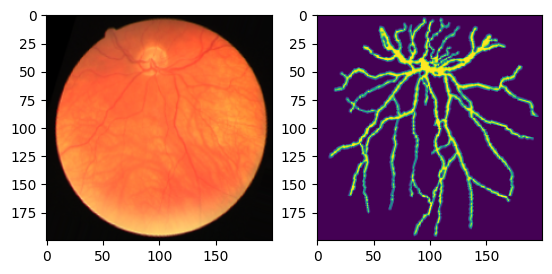

In [9]:
fig, axes = plt.subplots(1, 2)
sample = dataset_train.take(1)
x, y = sample.as_numpy_iterator().next()
axes[0].imshow(x[0])
axes[1].imshow(y[0], vmin=0, vmax=1)
np.unique(y[0])

In [10]:
from glob import glob
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# steps_per_epoch = (2 * len(X_train)) // Configuration().batch_size
steps_per_epoch = 1


checkpoints = glob(
    os.path.join(os.path.dirname(Configuration().model_checkpoint_path), '*.keras')
)
checkpoints = False
if checkpoints:
    # Model with latest creation time
    model = load_model(max(checkpoints, key=os.path.getctime))
else:
    model = build_model(UNet, Configuration(), steps_per_epoch)
    model.build()

# Save model every epoch
checkpoint = ModelCheckpoint(
    filepath=Configuration().model_checkpoint_path,
    save_best_only=True,
    monitor='loss'
)

history = model.fit(
    dataset_train,
    steps_per_epoch=steps_per_epoch,
    epochs=Configuration().n_epochs,
    callbacks=[checkpoint]
)